In [2]:
# Importando libs
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
tb_job = pd.read_csv('/home/whitehat000142/Documents/Repositorios/Projetos-ML/Dados/tb_job.csv').set_index('id')
tb_cadastro = pd.read_csv('/home/whitehat000142/Documents/Repositorios/Projetos-ML/Dados/tb_cadastro.csv').set_index('id')
tb_atraso = pd.read_csv('/home/whitehat000142/Documents/Repositorios/Projetos-ML/Dados/tb_atraso.csv').set_index('id')
tb_cadastro.head()

,tp_sexo,uf,status_civil,n_dependentes,casa_propria
id,,,,,
8927457,M,SP,SOLTEIRO,0,1
22009007,M,SP,SOLTEIRO,0,0
30794041,F,SP,SOLTEIRO,0,0
13342495,M,RJ,SOLTEIRO,0,0
73110407,M,SP,C,0,1


In [3]:
tb_job.head()

,escolaridade,tempo_empregado,modelo_renda_v2,classe_renda_inf
id,,,,
42543947,Ensino Fundamental,9,1517,B
49524184,Ensino Fundamental,9,1654,B
29697248,Ensino Superior,5,1468,A
61147127,Ensino Fundamental,4,1535,B
25601658,Ensino Médio,14,1399,A


In [4]:
tb_atraso.head()

,max_dias_atraso_6m,programa_reneg
id,,
59692101,59,NÃO
3621563,64,NÃO
17013828,71,SIM
56633600,52,NÃO
34502897,56,NÃO


In [5]:
# junção das tabelas
data = pd.concat([tb_job,
                  tb_cadastro,
                  tb_atraso],
                 axis = 1)
data.head()

,escolaridade,tempo_empregado,modelo_renda_v2,classe_renda_inf,tp_sexo,uf,status_civil,n_dependentes,casa_propria,max_dias_atraso_6m,programa_reneg
id,,,,,,,,,,,
42543947,Ensino Fundamental,9,1517,B,M,SP,CASADO,0,1,62,NÃO
49524184,Ensino Fundamental,9,1654,B,F,SP,CASADO,0,1,56,NÃO
29697248,Ensino Superior,5,1468,A,M,SP,CASADO,0,1,63,NÃO
61147127,Ensino Fundamental,4,1535,B,F,SP,SOLTEIRO,3,0,66,NÃO
25601658,Ensino Médio,14,1399,A,F,RJ,SOLTEIRO,0,0,64,NÃO


In [6]:
# dimensionalidade dos dados
data.shape

(249678, 11)

In [7]:
# informações da base de dados
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 249678 entries, 42543947 to 43879655
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   escolaridade        249678 non-null  object
 1   tempo_empregado     249678 non-null  int64 
 2   modelo_renda_v2     249678 non-null  int64 
 3   classe_renda_inf    249678 non-null  object
 4   tp_sexo             249678 non-null  object
 5   uf                  249678 non-null  object
 6   status_civil        249678 non-null  object
 7   n_dependentes       249678 non-null  int64 
 8   casa_propria        249678 non-null  int64 
 9   max_dias_atraso_6m  249678 non-null  int64 
 10  programa_reneg      249678 non-null  object
dtypes: int64(5), object(6)
memory usage: 22.9+ MB


In [8]:
def contar_linhas_duplicadas(data_frame):
    '''Recebe um DataFrame e retorna se o DataFrame possui
    linhas duplicadas ou não.'''
    contar_duplicidade = data_frame.duplicated().sum()
    if contar_duplicidade > 0:
        return True
    return False
    
def colunas_constantes(data_frame):
    '''Retorna uma lista com as colunas constantes do DataFrame.'''
    return data_frame.columns[data_frame.nunique() == 1].tolist()
    
def low_variance(data_frame, threshold):
    '''Conta a variância das variáveis do DataFrame, mapeando low variance.'''
    minmax_scaler = MinMaxScaler()
    numerical_columns = data.select_dtypes('number')
    data_frame_scaled = pd.DataFrame(minmax_scaler.fit_transform(numerical_columns),
    columns = numerical_columns.columns.tolist())
    low_variance = list()
    for column in data_frame_scaled:
        var = data_frame_scaled[column].var()
        if var < threshold:
            low_variance.append(column)
    return low_variance
    
def pct_nan(data_frame):
    '''Mensura o percentual de NaN.'''
    return np.multiply(data_frame.isna().sum() / data_frame.shape[0], 100).round(2)

In [9]:
# sumário estatístico das variáveis
data.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
tempo_empregado,249678.0,10.0,3.2,0.0,8.0,10.0,12.0,27.0
modelo_renda_v2,249678.0,1769.2,351.7,1200.0,1513.0,1704.0,2037.0,9841.0
n_dependentes,249678.0,0.5,0.9,0.0,0.0,0.0,1.0,4.0
casa_propria,249678.0,0.2,0.4,0.0,0.0,0.0,0.0,1.0
max_dias_atraso_6m,249678.0,60.0,7.7,28.0,55.0,60.0,65.0,95.0


In [10]:
# check de missing
data.isna().sum()

escolaridade          0
tempo_empregado       0
modelo_renda_v2       0
classe_renda_inf      0
tp_sexo               0
uf                    0
status_civil          0
n_dependentes         0
casa_propria          0
max_dias_atraso_6m    0
programa_reneg        0
dtype: int64

In [11]:
# valores únicos em cada coluna
data.nunique()

escolaridade             4
tempo_empregado         27
modelo_renda_v2       1550
classe_renda_inf         3
tp_sexo                  2
uf                       2
status_civil             4
n_dependentes            5
casa_propria             2
max_dias_atraso_6m      68
programa_reneg           2
dtype: int64

In [12]:
# check de linhas duplicadas
contar_linhas_duplicadas(data)

True

In [13]:
# remove linhas duplicadas
data.drop_duplicates(inplace = True)

# check de linhas duplicadas
contar_linhas_duplicadas(data)

False

Text(0.5, 1.0, 'Escolaridade')

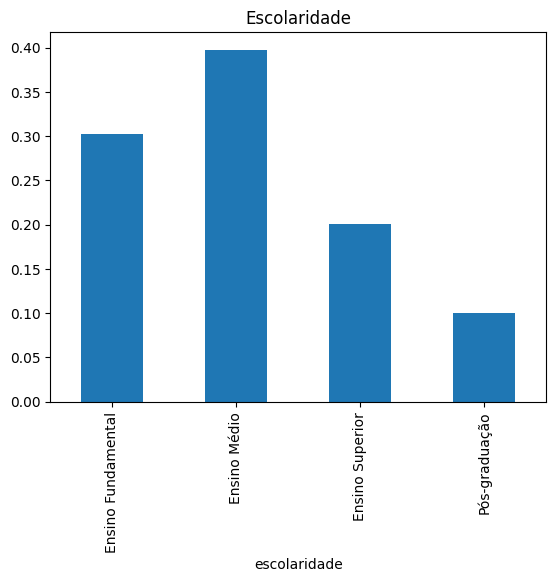

In [14]:
data.escolaridade.value_counts(normalize = True).sort_index().plot(kind = 'bar')
plt.title('Escolaridade')

Text(0.5, 1.0, 'Clientes por nível de renda')

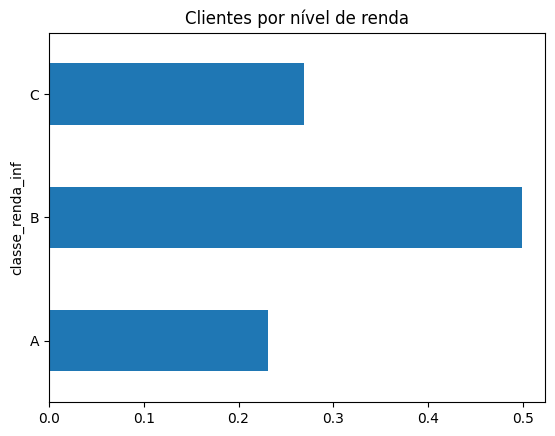

In [15]:
data['classe_renda_inf'].value_counts(normalize = True).sort_index().plot(kind = 'barh')
plt.title('Clientes por nível de renda')

Text(0.5, 0.98, 'Distribuição das variáveis')

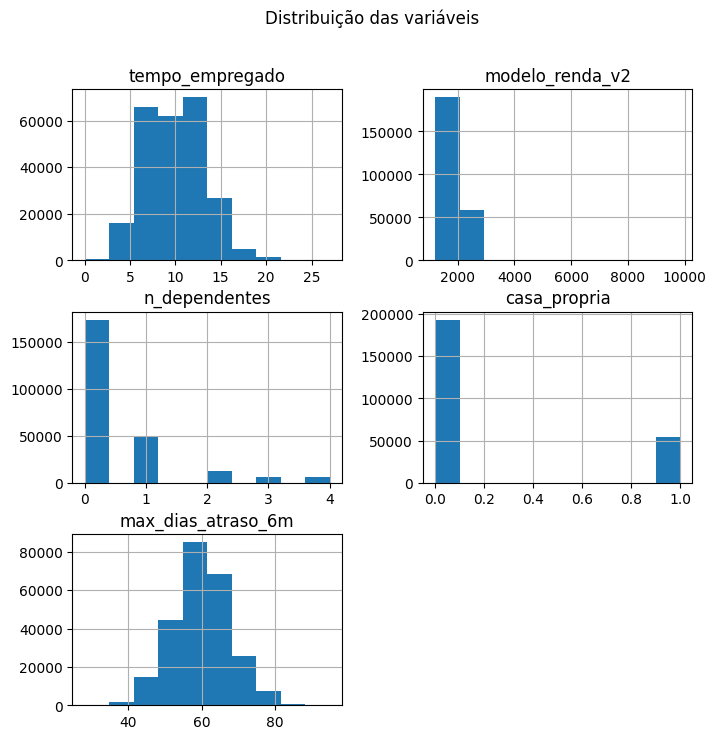

In [16]:
fig, ax = plt.subplots(figsize = (8,8))
data[['tempo_empregado', 'modelo_renda_v2', 'n_dependentes', 'casa_propria', 'max_dias_atraso_6m']].hist(ax =ax)
fig.suptitle('Distribuição das variáveis')

In [17]:
# seleciona colunas do tipo object
cat_cols = data.select_dtypes(include = 'object')

In [18]:
# verifica valores únicos de cada coluna do tipo object
for col in cat_cols:
    print(col)
    print(cat_cols[col].unique());print()

escolaridade
['Ensino Fundamental' 'Ensino Superior' 'Ensino Médio' 'Pós-graduação']

classe_renda_inf
['B' 'A' 'C']

tp_sexo
['M' 'F']

uf
['SP' 'RJ']

status_civil
['CASADO' 'SOLTEIRO' 'C' 'CAsado']

programa_reneg
['NÃO' 'SIM']



In [19]:
# tratamento das variáveis
data['escolaridade'] = data.escolaridade.map({'Ensino Fundamental': 1, 'Ensino Médio': 2, 'Ensino Superior': 3,'Pós-graduação': 4 })

data['classe_renda_inf'] = data.classe_renda_inf.map({'A': 1, 'B': 2, 'C': 3 })
data['tp_sexo'] = data.tp_sexo.map({'M': 1, 'F': 0})
data['uf'] = data.uf.map({'SP': 1, 'RJ': 0})
data['status_civil'] = data.status_civil.str.lower().map({'solteiro': 0, 'c': 1, 'casado': 1})
data['programa_reneg'] = data.programa_reneg.map({'SIM': 1, 'NÃO': 0})
data['target'] = data.max_dias_atraso_6m.apply(lambda x: 1 if x >= 60 else 0)

In [20]:
# features: variáveis explicativas do modelo
X = data.drop(columns = ['target', 'max_dias_atraso_6m'])

# target: variável-alvo da previsão
y = data.target
y.value_counts(normalize = True)

SEED = 1321
# separa os dados em conjunto de treinamento e conjunto de teste
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = SEED,test_size = 0.3)

In [21]:
# define validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
reglog = LogisticRegression()
cv_scores_reglog = cross_validate(estimator = reglog,X = X_train,y = y_train,scoring = 'roc_auc',cv = cv,return_train_score = True)

cv_scores_reglog

{'fit_time': array([3.92820358, 3.51390123, 3.66386271, 3.44343281, 3.68376279]),
 'score_time': array([0.05043697, 0.04320383, 0.04334927, 0.10480738, 0.04362869]),
 'test_score': array([0.82007736, 0.82020262, 0.82777606, 0.82604788, 0.8127482 ]),
 'train_score': array([0.82066267, 0.81981301, 0.82547394, 0.82766233, 0.81303019])}

In [22]:
cv_scores_reglog['test_score'].mean()

0.8213704244590841

In [23]:
cv_scores_reglog['train_score'].mean()

0.8213284266450429

In [24]:
# define validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)

dt_clf = DecisionTreeClassifier()

cv_scores_dt = cross_validate(estimator = dt_clf,X = X_train,y = y_train,scoring = 'roc_auc',cv = cv,return_train_score = True)

cv_scores_dt

{'fit_time': array([1.63527846, 1.84403491, 1.79378867, 2.04703307, 1.87463331]),
 'score_time': array([0.05971742, 0.08161974, 0.0744369 , 0.06258917, 0.06183219]),
 'test_score': array([0.75409465, 0.75572306, 0.75838224, 0.75352118, 0.75573476]),
 'train_score': array([0.99906074, 0.99906398, 0.99905709, 0.99907839, 0.99904935])}

In [25]:
cv_scores_dt['train_score'].mean()

0.999061909565602

In [26]:
cv_scores_dt['test_score'].mean()

0.7554911776314888

In [27]:
# define validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
dt_clf = DecisionTreeClassifier(max_depth = 5)
cv_scores_dt = cross_validate(estimator = dt_clf,X = X_train,y = y_train,scoring = 'roc_auc',cv = cv,return_train_score = True)
cv_scores_dt['train_score'].mean(),cv_scores_dt['test_score'].mean()

(0.8887857303240605, 0.8873817554892716)

In [28]:
# define validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)

rf_clf = RandomForestClassifier(max_depth = 5)

cv_scores_rf = cross_validate(estimator = rf_clf,X = X_train,y = y_train,scoring = 'roc_auc',cv = cv,return_train_score = True)

cv_scores_rf['train_score'].mean(),cv_scores_rf['test_score'].mean()


(0.8890679211760354, 0.8867754535066765)

In [29]:
# define validação cruzada
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state = SEED)
param_grid = {'criterion' : ['gini', 'entropy'],
              'max_depth' : list(range(1, 11)),
              'min_samples_leaf' : range(2, 21, 2),
              'min_samples_split' : range(2, 41, 5),}
rf_model = RandomForestClassifier(max_depth = 5)
rf_model = RandomizedSearchCV(estimator = rf_model,param_distributions = param_grid,scoring = 'roc_auc',random_state = SEED,n_jobs = -1,verbose = 1,n_iter = 3)
rf_model.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(estimator=RandomForestClassifier(max_depth=5), n_iter=3,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_samples_leaf': range(2, 21, 2),
                                        'min_samples_split': range(2, 41, 5)},
                   random_state=1321, scoring='roc_auc', verbose=1)

In [30]:
y_pred_proba_train = rf_model.predict_proba(X_train)
y_pred_proba_test = rf_model.predict_proba(X_test)
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)
roc_auc_train = roc_auc_score(y_train, y_pred_proba_train[:, 1])
roc_auc_test = roc_auc_score(y_test, y_pred_proba_test[:, 1])
roc_auc_train, roc_auc_test

(0.8911488350267678, 0.8851463939436982)

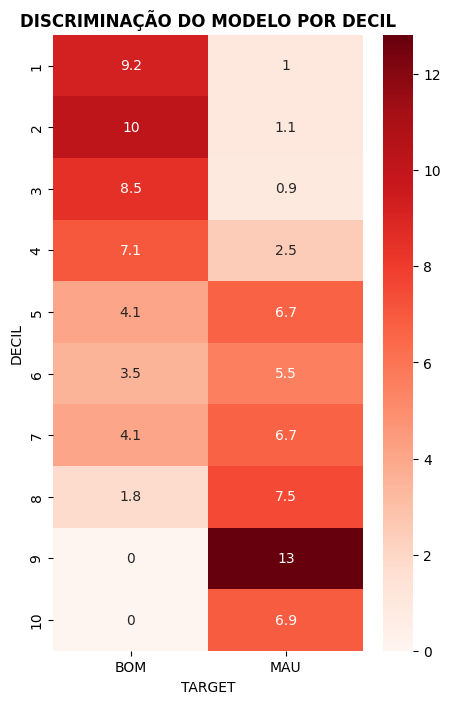

In [31]:
result = X_test.reset_index()[['id']]
result['SCORE'] = np.multiply(y_pred_proba_test[:, 1], 1000).astype(int)
result['TARGET'] = y_test.values
result['DECIL'] = pd.qcut(result.SCORE, 10, labels = [i for i in range(1, 11)])
decile_df = pd.crosstab(result['DECIL'], result['TARGET'].map({1:'MAU', 0: 'BOM'}),normalize = True) * 100
fig, ax = plt.subplots(figsize = (5, 8))
ax.set_title('DISCRIMINAÇÃO DO MODELO POR DECIL', weight = 'bold')
sns.heatmap(decile_df, cmap = 'Reds', annot = True, ax = ax)
plt.show()

In [32]:
def classificar_cliente(score):
    if score < 300: return 'A'
    elif 300 <= score <= 600: return 'B'
    elif score > 600: return 'C'
result['DECISION'] = result.SCORE.apply(classificar_cliente)
result

,id,SCORE,TARGET,DECIL,DECISION
0,43703045,94,0,1,A
1,45653219,990,1,9,C
2,83160789,903,1,8,C
3,59513450,611,0,5,C
4,32977762,992,1,10,C
...,...,...,...,...,...
74391,37465972,621,1,7,C
74392,43374175,622,1,7,C
74393,49268233,100,1,2,A
74394,1832769,104,0,3,A
